In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("viridis")

# Load your data
csv_file = './metrics_data_aggregated_rate.csv'  # Update with your file path
df = pd.read_csv(csv_file)

# Calculate scheduling time per request
# df['scheduling_time_per_request'] = df['total_scheduling_time'] / df['completed_requests']
df['scheduling_time_per_step'] = df['total_scheduling_time'] / df['steps']
# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (336, 21)

Column names:
['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 'rank', 'rate', 'output_throughput', 'completed_requests', 'adapter_rates', 'max_lora_loading_time', 'avg_batch_size', 'avg_waiting_queue', 'max_lora_loads_from_memory', 'max_lora_loads_from_disk', 'max_lora_loads_from_memory_corrected', 'total_scheduling_time', 'mean_itl_ms', 'processed_tokens', 'duration', 'mean_loras_by_batch', 'steps', 'scheduling_time_per_step']

First few rows:


,gpu_loras,cpu_loras,cpu_gpu_diff,rank,rate,output_throughput,completed_requests,adapter_rates,max_lora_loading_time,avg_batch_size,...,max_lora_loads_from_memory,max_lora_loads_from_disk,max_lora_loads_from_memory_corrected,total_scheduling_time,mean_itl_ms,processed_tokens,duration,mean_loras_by_batch,steps,scheduling_time_per_step
0,8,8,0,8,1.0,226.379365,588,0.125000,0.067586,5.874552,...,8.0,8.0,0.0,0.993855,25.847656,135828,600.001684,4.065602,23301,0.000043
1,8,16,8,8,1.0,225.609058,586,0.062500,2.273233,6.093190,...,331.0,16.0,315.0,0.949654,26.471115,135366,600.002504,4.764841,22833,0.000042
2,8,32,24,8,1.0,225.994110,587,0.031250,3.786232,6.061151,...,559.0,32.0,527.0,0.968009,26.226961,135597,600.002363,5.200201,23105,0.000042
3,8,64,56,8,1.0,227.919238,592,0.015625,5.089392,6.043011,...,733.0,64.0,669.0,0.987342,26.828487,136752,600.002005,5.618815,22667,0.000044
4,8,128,120,8,1.0,227.533774,591,0.007812,6.284206,6.197133,...,869.0,128.0,741.0,0.992056,27.320559,136521,600.003233,5.775044,22378,0.000044


In [ ]:
csv_file = './metrics_data_adapter_rates.csv' 
adapter_rate_df = pd.read_csv(csv_file)

# Calculate scheduling time per request
adapter_rate_df['scheduling_time_per_step'] = adapter_rate_df['total_scheduling_time'] / adapter_rate_df['steps']
combined = pd.concat([df, adapter_rate_df], ignore_index=True)
df=combined.copy()

In [3]:
# Define potential explanatory factors
potential_factors = ['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 'rate', 
                    'avg_batch_size', 'avg_waiting_queue',
                    'max_lora_loads_from_memory_corrected']

# Calculate correlations for all ranks combined
correlations = []
for factor in potential_factors:
    if factor in df.columns:
        corr, p_value = pearsonr(df[factor], df['scheduling_time_per_step'])
        correlations.append({
            'factor': factor,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# Create correlation dataframe and sort by absolute correlation
correlations_df = pd.DataFrame(correlations)
correlations_df['abs_corr'] = correlations_df['correlation'].abs()
correlations_df = correlations_df.sort_values('abs_corr', ascending=False)

# Display correlations
print("Pearson Correlations with scheduling_time_per_step:")
for _, row in correlations_df.iterrows():
    sig = '*' if row['significant'] else ' '
    print(f"{row['factor']:30} r = {row['correlation']:+.4f} (p = {row['p_value']:.4f}) {sig}")

Pearson Correlations with scheduling_time_per_step:
avg_waiting_queue              r = +0.7303 (p = 0.0000) *
avg_batch_size                 r = +0.7140 (p = 0.0000) *
rate                           r = +0.5865 (p = 0.0000) *
cpu_gpu_diff                   r = +0.3717 (p = 0.0000) *
gpu_loras                      r = -0.2695 (p = 0.0000) *
max_lora_loads_from_memory_corrected r = -0.1748 (p = 0.0000) *
cpu_loras                      r = +0.1387 (p = 0.0001) *


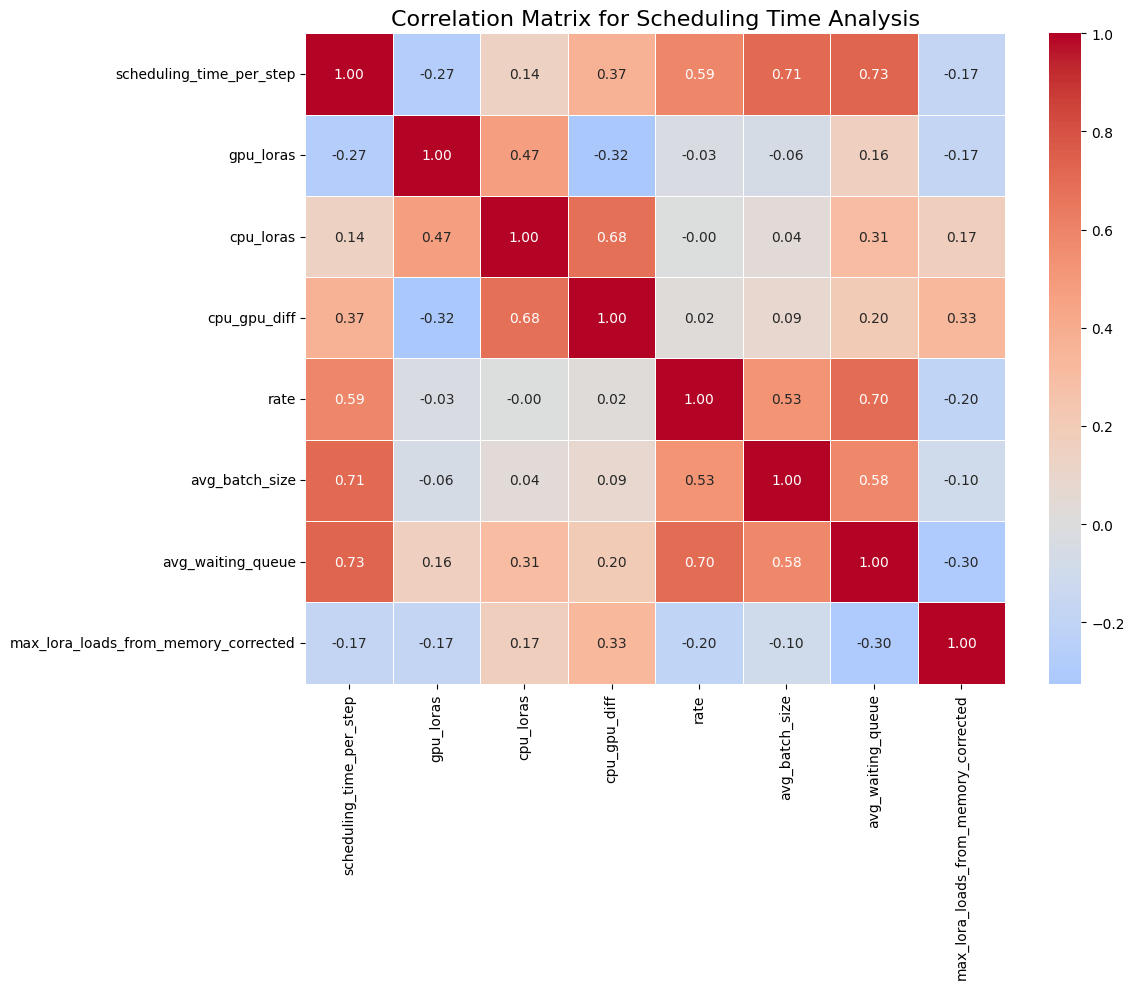

In [4]:
# Create correlation heatmap
plt.figure(figsize=(12, 10))

# Select variables for correlation matrix
correlation_vars = ['scheduling_time_per_step'] + [f for f in potential_factors if f in df.columns]
corr_matrix = df[correlation_vars].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation Matrix for Scheduling Time Analysis', fontsize=16)
plt.tight_layout()
plt.show()

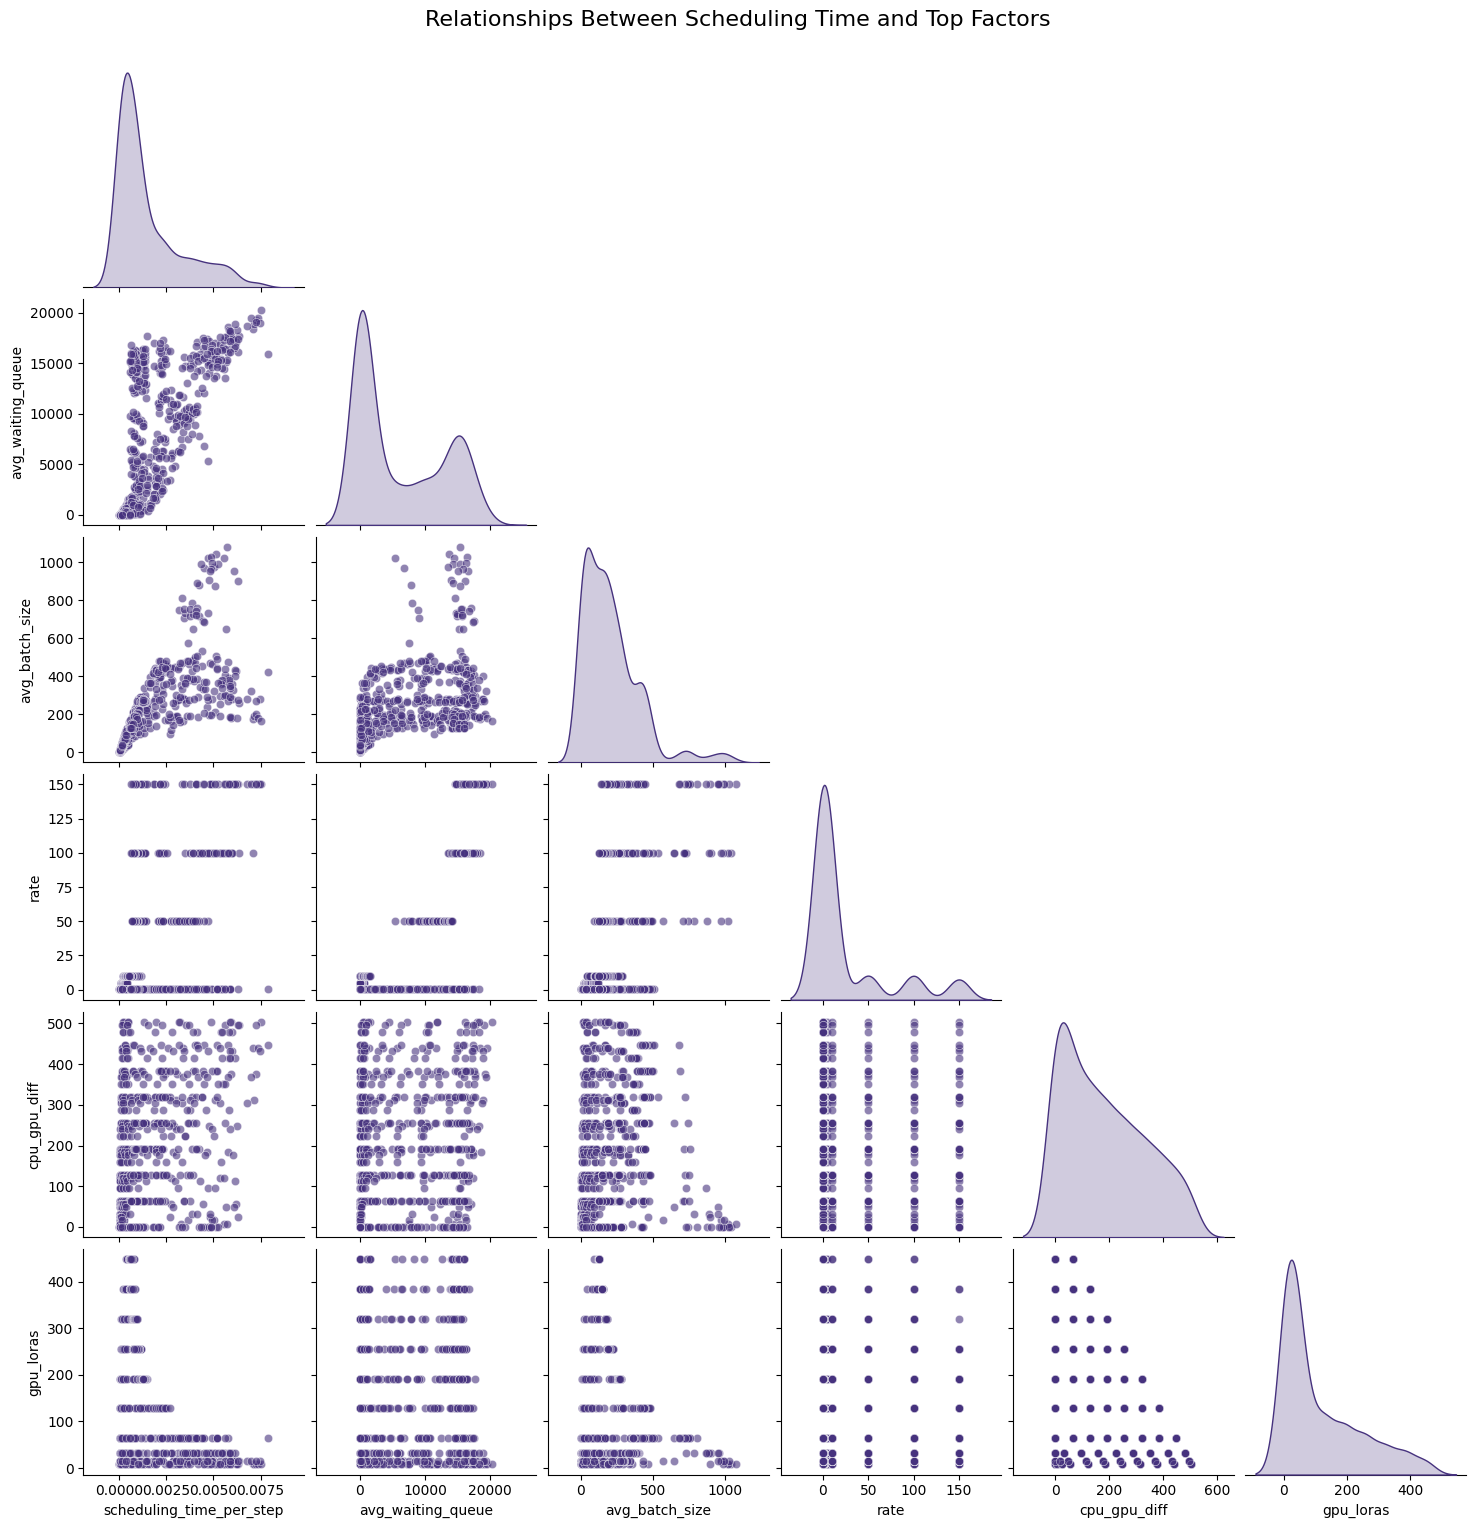

In [5]:
# Select top 5 correlated factors (or fewer if not available)
num_factors = min(5, len(correlations_df))
top_factors = correlations_df.head(num_factors)['factor'].tolist()
scatter_vars = ['scheduling_time_per_step'] + top_factors

# Create pairplot
if len(scatter_vars) > 1:
    g = sns.pairplot(df[scatter_vars], height=2.5, corner=True, diag_kind='kde', plot_kws={'alpha': 0.6})
    g.fig.suptitle('Relationships Between Scheduling Time and Top Factors', fontsize=16, y=1.02)
    plt.show()

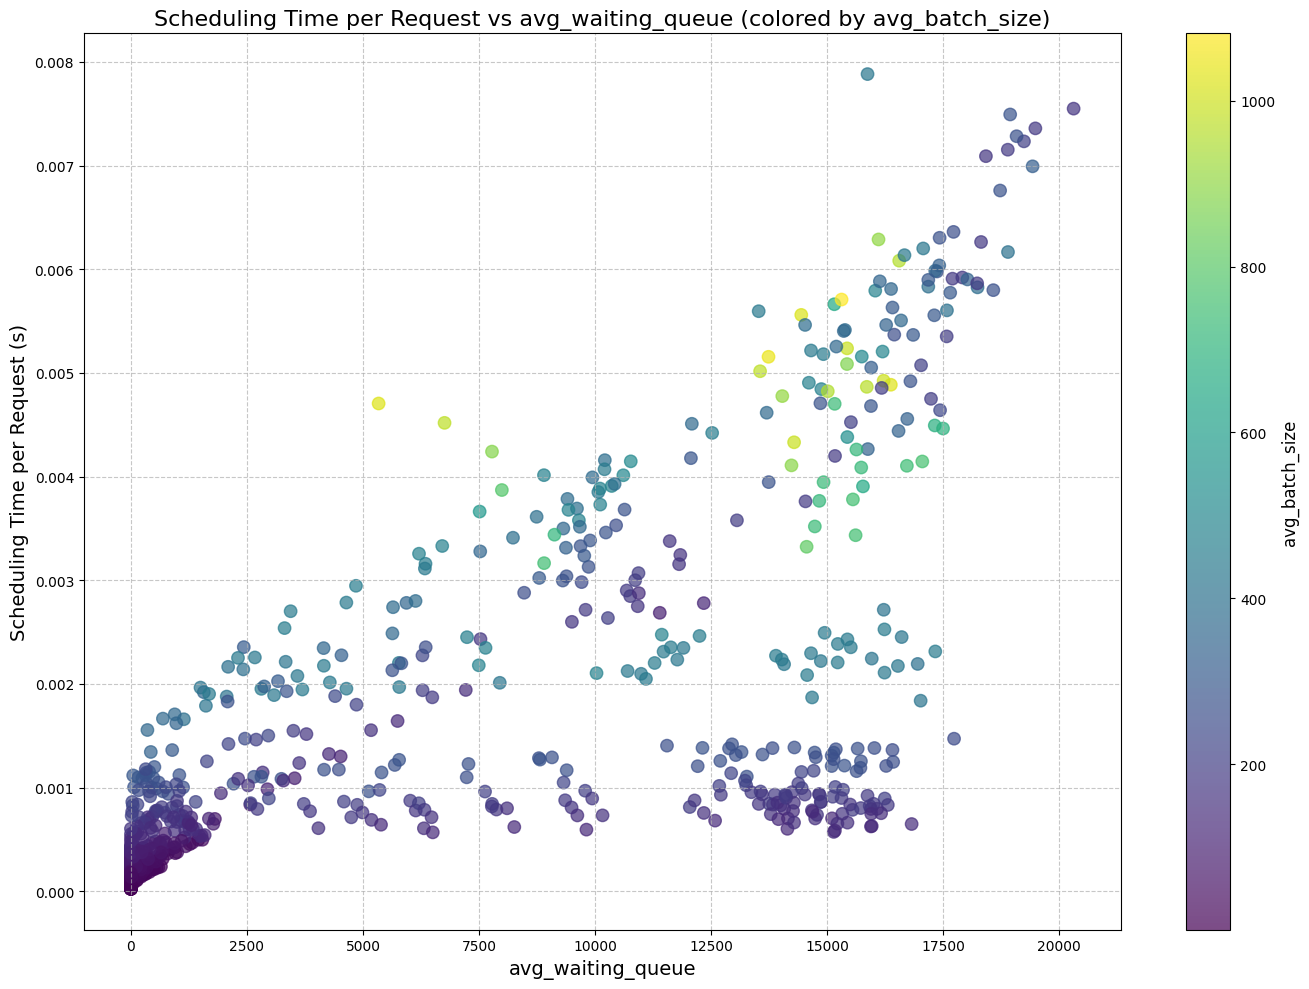

In [6]:
# Create multi-factor visualization for the most highly correlated factors
if len(top_factors) >= 2:
    factor1 = top_factors[0]
    factor2 = top_factors[1]
    
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot colored by second factor
    scatter = plt.scatter(df[factor1], df['scheduling_time_per_step'], 
                        c=df[factor2], cmap='viridis', alpha=0.7, s=80)
    
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label(factor2, fontsize=12)
    
    plt.xlabel(factor1, fontsize=14)
    plt.ylabel('Scheduling Time per Request (s)', fontsize=14)
    plt.title(f'Scheduling Time per Request vs {factor1} (colored by {factor2})', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

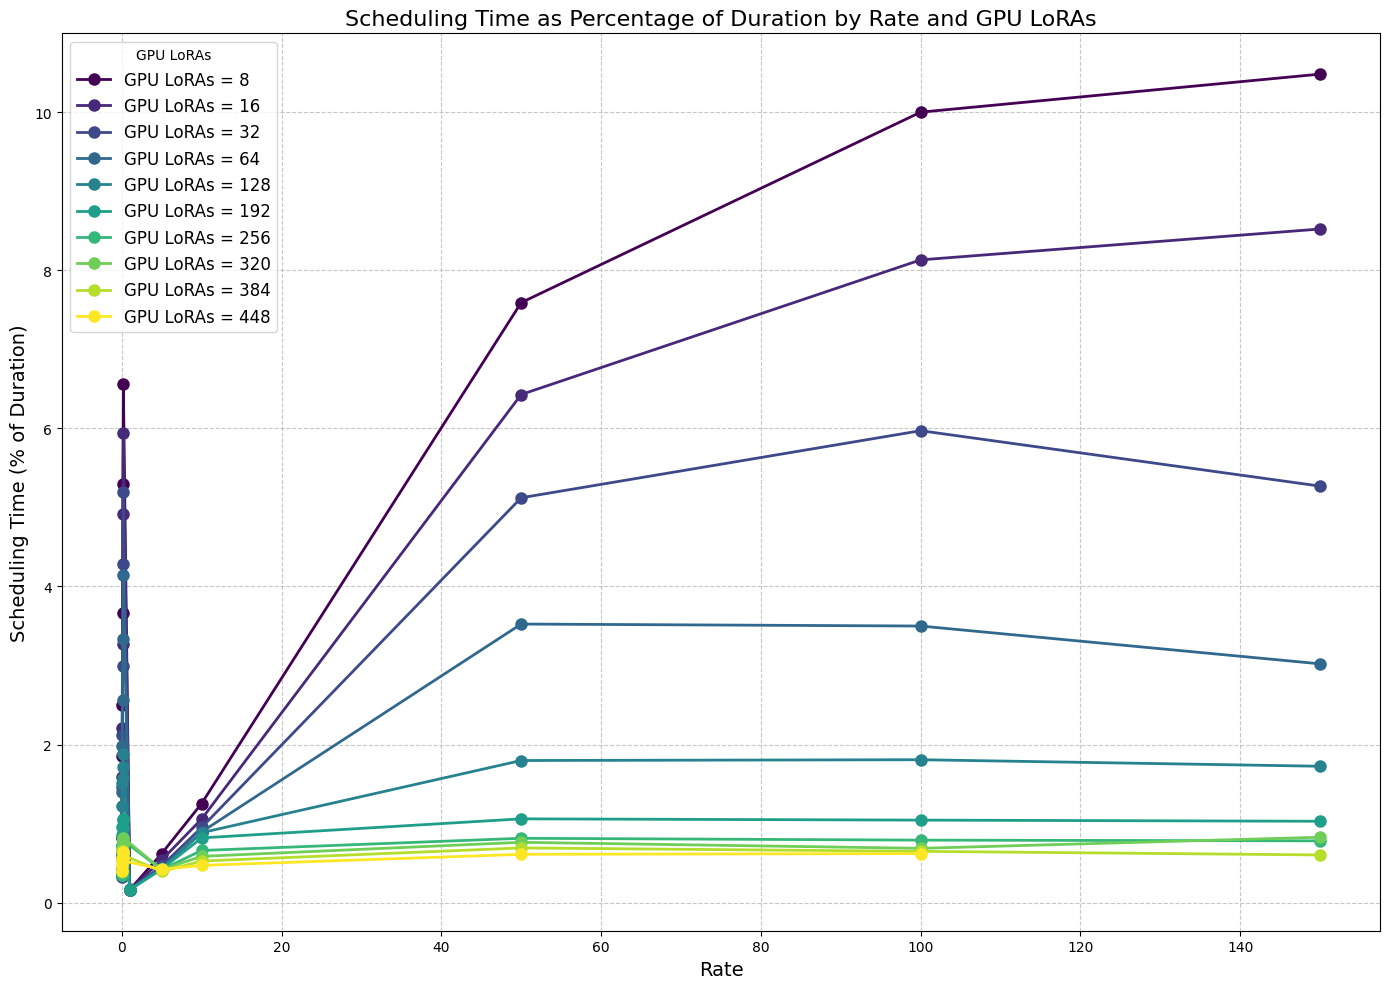


Average scheduling time percentage by GPU LoRAs and Rate:
rate       0.01    0.02    0.05    0.07    0.10    0.15    0.20    1.00    \
gpu_loras                                                                   
8            0.43    0.82    1.85    2.50    3.66    5.30    6.56    0.16   
16           0.35    0.64    1.59    2.21    3.27    4.92    5.94    0.16   
32           0.33    0.59    1.47    2.12    2.99    4.29    5.19    0.16   
64           0.34    0.59    1.40    1.99    2.56    3.34    4.15    0.17   
128          0.35    0.60    1.23    1.52    1.58    1.72    1.89    0.17   
192          0.36    0.59    0.86    0.96    0.95    1.05    1.05    0.17   
256          0.35    0.56    0.72    0.73    0.77    0.82    0.79     NaN   
320          0.39    0.57    0.67    0.67    0.74    0.79    0.82     NaN   
384          0.41    0.52    0.56    0.66    0.66    0.62    0.60     NaN   
448          0.40    0.47    0.54    0.54    0.56    0.64    0.53     NaN   

rate       5.00 

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Calculate scheduling time per request as percentage of duration
df['scheduling_time_normalized_duration'] = (df['total_scheduling_time'] / df['duration']) * 100

# Sort the DataFrame by rate and gpu_loras for proper line plotting
df_sorted = df.sort_values(by=['gpu_loras', 'rate'])

# Create the figure
plt.figure(figsize=(14, 10))

# Get unique GPU LoRAs values
gpu_loras_values = sorted(df['gpu_loras'].unique())

# Define a color map for different GPU LoRAs values
colors = plt.cm.viridis(np.linspace(0, 1, len(gpu_loras_values)))

# Plot a line for each GPU LoRA value
for i, gpu_lora in enumerate(gpu_loras_values):
    # Filter data for current GPU LoRA
    gpu_data = df_sorted[df_sorted['gpu_loras'] == gpu_lora]
    
    # Group by rate and calculate mean of scheduling_time_normalized_duration
    # (in case there are multiple data points for the same gpu_lora and rate)
    gpu_rate_avg = gpu_data.groupby('rate')['scheduling_time_normalized_duration'].mean().reset_index()
    
    # Sort by rate to ensure proper line connection
    gpu_rate_avg = gpu_rate_avg.sort_values('rate')
    
    # Plot the line
    plt.plot(gpu_rate_avg['rate'], gpu_rate_avg['scheduling_time_normalized_duration'], 
             'o-', linewidth=2, markersize=8, color=colors[i], 
             label=f'GPU LoRAs = {gpu_lora}')

# Configure the plot
plt.xlabel('Rate', fontsize=14)
plt.ylabel('Scheduling Time (% of Duration)', fontsize=14)
plt.title('Scheduling Time as Percentage of Duration by Rate and GPU LoRAs', fontsize=16)
plt.legend(title='GPU LoRAs', fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()
plt.show()

# Optional: If you want to see the actual values
print("\nAverage scheduling time percentage by GPU LoRAs and Rate:")
summary_table = df.groupby(['gpu_loras', 'rate'])['scheduling_time_normalized_duration'].mean().unstack()
print(summary_table.round(2))

Plot saved to aggregated_rate/plots/scheduling/scheduling_by_step_gpu_cpu_loras.png


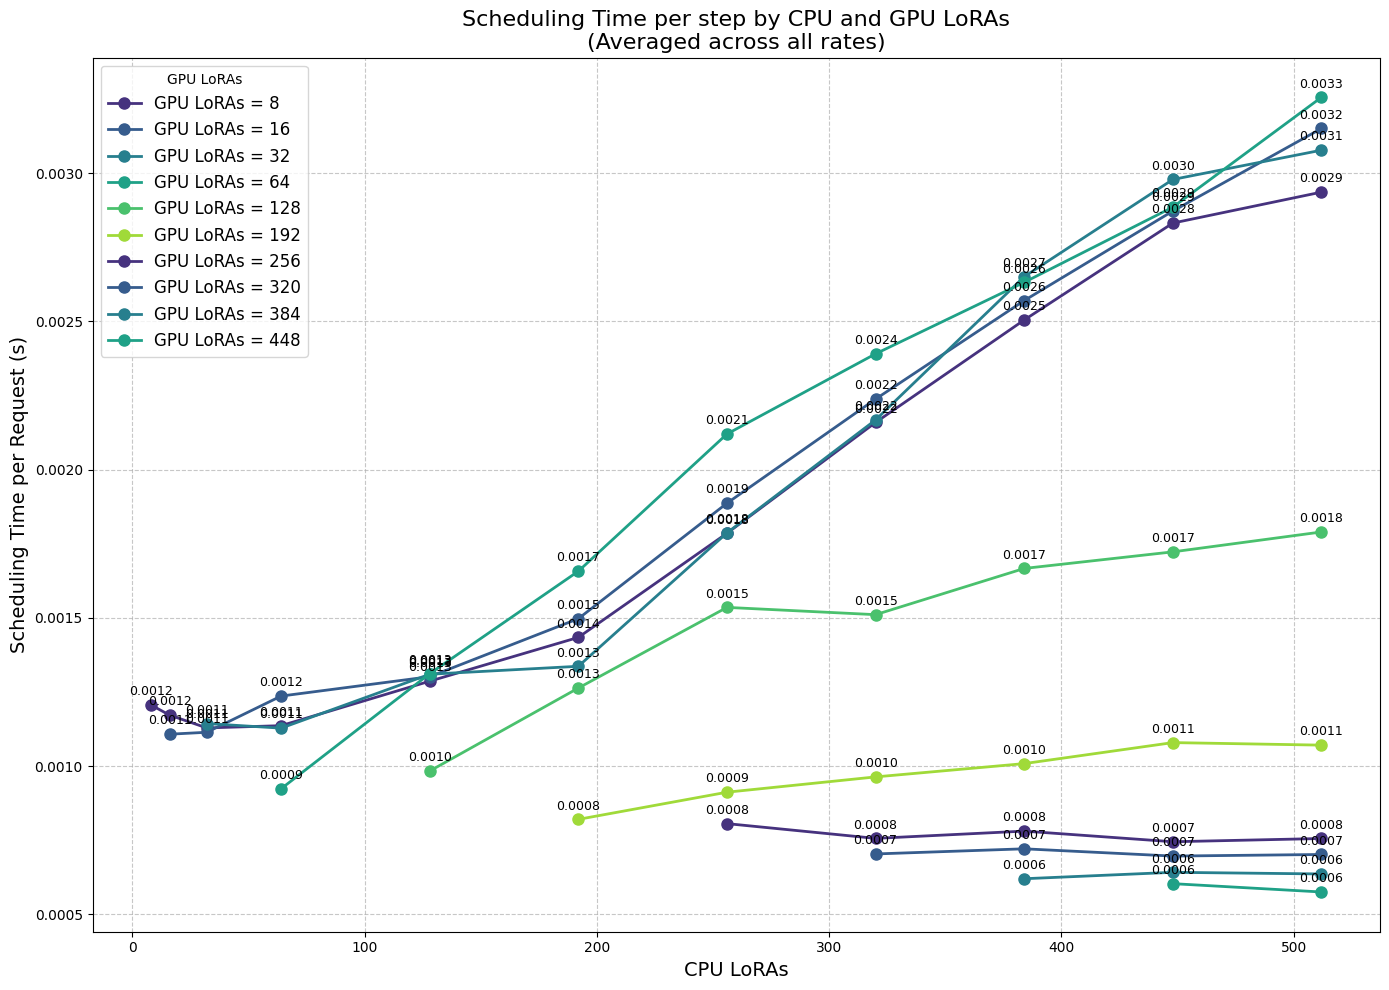


Scheduling time per step by GPU and CPU LoRAs:
cpu_loras       8         16        32        64        128       192  \
gpu_loras                                                               
8          0.001206  0.001172  0.001129  0.001137  0.001287  0.001434   
16              NaN  0.001108  0.001114  0.001236  0.001302  0.001497   
32              NaN       NaN  0.001144  0.001128  0.001310  0.001337   
64              NaN       NaN       NaN  0.000924  0.001312  0.001658   
128             NaN       NaN       NaN       NaN  0.000984  0.001264   
192             NaN       NaN       NaN       NaN       NaN  0.000821   
256             NaN       NaN       NaN       NaN       NaN       NaN   
320             NaN       NaN       NaN       NaN       NaN       NaN   
384             NaN       NaN       NaN       NaN       NaN       NaN   
448             NaN       NaN       NaN       NaN       NaN       NaN   

cpu_loras       256       320       384       448       512  
gpu_loras    

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# First, calculate the mean scheduling_time_per_request across all rates for each GPU LoRA and CPU LoRA combination
df_avg = df.groupby(['gpu_loras', 'cpu_loras'])['scheduling_time_per_step'].mean().reset_index()

# Sort the DataFrame by cpu_loras for proper line plotting
df_avg = df_avg.sort_values(by=['gpu_loras', 'cpu_loras'])

# Create the figure
plt.figure(figsize=(14, 10))

# Get unique GPU LoRAs values
gpu_loras_values = sorted(df_avg['gpu_loras'].unique())

# Plot a line for each GPU LoRA value
for i, gpu_lora in enumerate(gpu_loras_values):
    # Filter data for current GPU LoRA
    gpu_data = df_avg[df_avg['gpu_loras'] == gpu_lora]
    
    # Sort by CPU LoRAs to ensure proper line connection
    gpu_data = gpu_data.sort_values('cpu_loras')
    
    # Plot the line - let matplotlib assign colors automatically from default cycle
    plt.plot(gpu_data['cpu_loras'], gpu_data['scheduling_time_per_step'], 
             'o-', linewidth=2, markersize=8,
             label=f'GPU LoRAs = {gpu_lora}')
    
    # Add data labels (optional)
    for _, row in gpu_data.iterrows():
        plt.annotate(f"{row['scheduling_time_per_step']:.4f}", 
                    (row['cpu_loras'], row['scheduling_time_per_step']),
                    textcoords="offset points", xytext=(0, 7), 
                    ha='center', fontsize=9)

# Configure the plot
plt.xlabel('CPU LoRAs', fontsize=14)
plt.ylabel('Scheduling Time per Request (s)', fontsize=14)
plt.title('Scheduling Time per step by CPU and GPU LoRAs\n(Averaged across all rates)', fontsize=16)
plt.legend(title='GPU LoRAs', fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

output_path = 'aggregated_rate/plots/scheduling/'
plot_path = os.path.join(output_path, f'scheduling_by_step_gpu_cpu_loras.png')
plt.savefig(plot_path, dpi=300)
print(f"Plot saved to {plot_path}")

plt.show()

# Optional: Show the summary table
print("\nScheduling time per step by GPU and CPU LoRAs:")
summary_table = df_avg.pivot(index='gpu_loras', columns='cpu_loras', values='scheduling_time_per_step')
print(summary_table.round(6))

# Optional: Show how many data points were averaged for each combination
count_table = df.groupby(['gpu_loras', 'cpu_loras'])['scheduling_time_per_step'].count().reset_index()
count_pivot = count_table.pivot(index='gpu_loras', columns='cpu_loras', values='scheduling_time_per_step')
print("\nNumber of data points averaged for each combination:")
print(count_pivot)

In [9]:
df.columns


Index(['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 'rank', 'rate',
       'output_throughput', 'completed_requests', 'adapter_rates',
       'max_lora_loading_time', 'avg_batch_size', 'avg_waiting_queue',
       'max_lora_loads_from_memory', 'max_lora_loads_from_disk',
       'max_lora_loads_from_memory_corrected', 'total_scheduling_time',
       'mean_itl_ms', 'processed_tokens', 'duration', 'mean_loras_by_batch',
       'steps', 'scheduling_time_per_step',
       'scheduling_time_normalized_duration'],
      dtype='object')

Plot saved to aggregated_rate/plots/scheduling/scheduling_proportion_by_gpu_cpu_loras.png


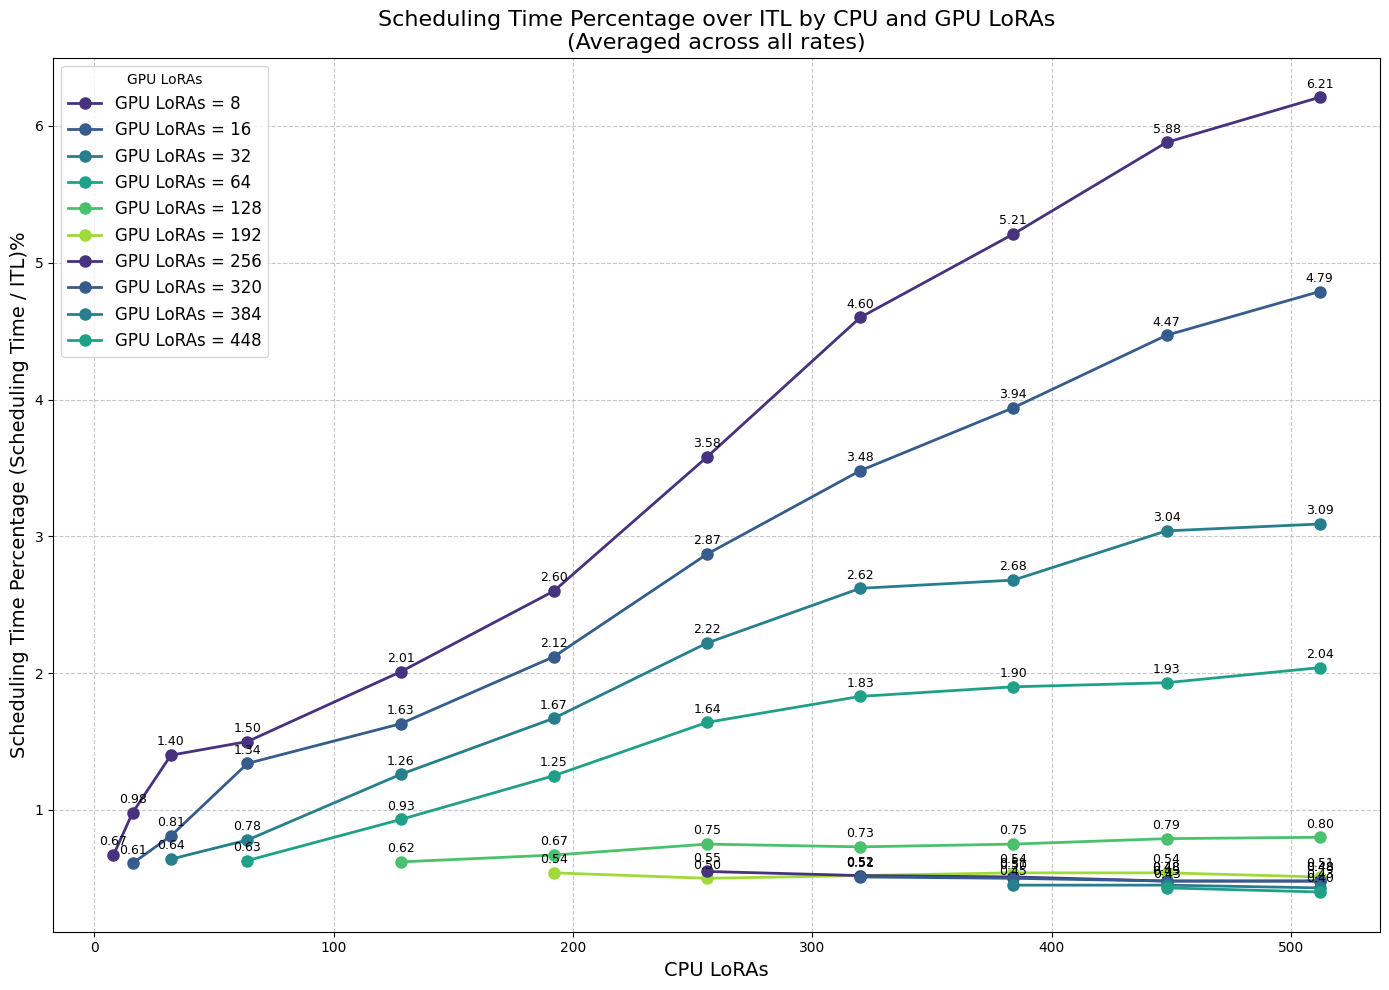


Scheduling time proportion by GPU and CPU LoRAs:
cpu_loras   8     16    32    64    128   192   256   320   384   448   512
gpu_loras                                                                  
8          0.67  0.98  1.40  1.50  2.01  2.60  3.58  4.60  5.21  5.88  6.21
16          NaN  0.61  0.81  1.34  1.63  2.12  2.87  3.48  3.94  4.47  4.79
32          NaN   NaN  0.64  0.78  1.26  1.67  2.22  2.62  2.68  3.04  3.09
64          NaN   NaN   NaN  0.63  0.93  1.25  1.64  1.83  1.90  1.93  2.04
128         NaN   NaN   NaN   NaN  0.62  0.67  0.75  0.73  0.75  0.79  0.80
192         NaN   NaN   NaN   NaN   NaN  0.54  0.50  0.52  0.54  0.54  0.51
256         NaN   NaN   NaN   NaN   NaN   NaN  0.55  0.52  0.51  0.48  0.48
320         NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.51  0.50  0.48  0.48
384         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.45  0.45  0.43
448         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.43  0.40

Number of data points averaged for ea

In [11]:
# Calculate the proportion of scheduling time per step to ITL
df['scheduling_proportion'] = ((df['scheduling_time_per_step']*1000) / df['mean_itl_ms'])*100

# Calculate the mean scheduling proportion across all rates for each GPU LoRA and CPU LoRA combination
df_avg = df.groupby(['gpu_loras', 'cpu_loras'])['scheduling_proportion'].mean().reset_index()
df_avg['scheduling_proportion']=df_avg['scheduling_proportion'].round(2)
# Sort the DataFrame by cpu_loras for proper line plotting
df_avg = df_avg.sort_values(by=['gpu_loras', 'cpu_loras'])

# Create the figure
plt.figure(figsize=(14, 10))

# Get unique GPU LoRAs values
gpu_loras_values = sorted(df_avg['gpu_loras'].unique())

# Plot a line for each GPU LoRA value
for i, gpu_lora in enumerate(gpu_loras_values):
    # Filter data for current GPU LoRA
    gpu_data = df_avg[df_avg['gpu_loras'] == gpu_lora]
    
    # Sort by CPU LoRAs to ensure proper line connection
    gpu_data = gpu_data.sort_values('cpu_loras')
    
    # Plot the line - let matplotlib assign colors automatically from default cycle
    plt.plot(gpu_data['cpu_loras'], gpu_data['scheduling_proportion'],
             'o-', linewidth=2, markersize=8,
             label=f'GPU LoRAs = {gpu_lora}')
    
    # Add data labels (optional)
    for _, row in gpu_data.iterrows():
        plt.annotate(f"{row['scheduling_proportion']:.2f}",
                     (row['cpu_loras'], row['scheduling_proportion']),
                     textcoords="offset points", xytext=(0, 7),
                     ha='center', fontsize=9)

# Configure the plot
plt.xlabel('CPU LoRAs', fontsize=14)
plt.ylabel('Scheduling Time Percentage (Scheduling Time / ITL)%', fontsize=14)
plt.title('Scheduling Time Percentage over ITL by CPU and GPU LoRAs\n(Averaged across all rates)', fontsize=16)
plt.legend(title='GPU LoRAs', fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

output_path = 'aggregated_rate/plots/scheduling/'
plot_path = os.path.join(output_path, f'scheduling_proportion_by_gpu_cpu_loras.png')
plt.savefig(plot_path, dpi=300)
print(f"Plot saved to {plot_path}")
plt.show()

# Optional: Show the summary table
print("\nScheduling time proportion by GPU and CPU LoRAs:")
summary_table = df_avg.pivot(index='gpu_loras', columns='cpu_loras', values='scheduling_proportion')
print(summary_table.round(6))

# Optional: Show how many data points were averaged for each combination
count_table = df.groupby(['gpu_loras', 'cpu_loras'])['scheduling_proportion'].count().reset_index()
count_pivot = count_table.pivot(index='gpu_loras', columns='cpu_loras', values='scheduling_proportion')
print("\nNumber of data points averaged for each combination:")
print(count_pivot)